<a href="https://colab.research.google.com/github/paulodiff/Coursera_Capstone/blob/master/Capstone_Project_The_Battle_of_Neighborhoods_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Rome City</font></h1>

## Capstone Project - The Battle of Neighborhoods (Week 2)

# New restaurant in Rome ?

The question is: what better place to start a new restaurant in Rome?

In this lab, we will try to find an optimal location and type for a new restaurant, using data analysis.

# Data

1. City location from Wikipedia
2. Rome Municipia location from Wikipedia
3. Number of restaurants, location and their type from Foursquare




In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Build and Explore Dataset  - Municipi - Neighborhood

In [127]:
data = [
('I',   41.9029, 12.4855),
('II',  41.9224, 12.4983),
('III', 41.9425, 12.5410),
('IV',  41.9216, 12.5537),
('V',   41.8913, 12.5510),
('VI',  41.8930, 12.4827),
('VII', 41.8501, 12.5642),
('VIII', 41.8599, 12.4982),
('IX',  41.7683, 12.5069),
('X',   41.7564, 12.3496),
('XI',  41.8389, 12.4438),
('XII', 41.8695, 12.4323),
('XIV', 41.9265, 12.4037),
('XV',  41.9409, 12.4708)
]

dfMunicipi = pd.DataFrame(data, columns=['Neighborhood', 'Latitude', 'Longitude'])
dfMunicipi

,Neighborhood,Latitude,Longitude
0,I,41.9029,12.4855
1,II,41.9224,12.4983
2,III,41.9425,12.5410
3,IV,41.9216,12.5537
4,V,41.8913,12.5510
5,VI,41.8930,12.4827
6,VII,41.8501,12.5642
7,VIII,41.8599,12.4982
8,IX,41.7683,12.5069
9,X,41.7564,12.3496


## Use geopy library to get the latitude and longitude values of Rome

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [128]:
address = 'Rome, IT'

'''
# geopy FAIL!
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
'''

# Rome  41.894802, 12.4853384
latitude = 41.894802
longitude = 12.4853384

rome_center = [latitude, longitude]
print('The geograpical coordinate of {}  are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Rome, IT  are 41.894802, 12.4853384.


## Create a map of Rome with municipi location

In [131]:
map_rome = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, municipio in zip(dfMunicipi['Latitude'], dfMunicipi['Longitude'], dfMunicipi['Neighborhood']):
    label = 'Mun {}'.format(municipio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome)  
    
map_rome

Let's get the geographical coordinates of Rome.

In [0]:
address = 'Rome, IT'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Rome, IT are 41.894802, 12.4853384.


## Define Foursquare Credentials and Version

In [132]:
CLIENT_ID = 'DGT40RM0EXP50RJ3BUXDVA3FXAWVSPZT1NHZ2ZXDAYZRF5JV' # your Foursquare ID
CLIENT_SECRET = '52HDECABK1P3XWFF5QI1BV2AGRO4P0DNJMLPS1GIAVWIS3JU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DGT40RM0EXP50RJ3BUXDVA3FXAWVSPZT1NHZ2ZXDAYZRF5JV
CLIENT_SECRET:52HDECABK1P3XWFF5QI1BV2AGRO4P0DNJMLPS1GIAVWIS3JU


## 2. Explore Neighborhoods in Rome

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [134]:
# type your answer here
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 500
rome_venues = getNearbyVenues(names=dfMunicipi['Neighborhood'],
                                   latitudes=dfMunicipi['Latitude'],
                                   longitudes=dfMunicipi['Longitude']
                                  )



I
II
III
IV
V
VI
VII
VIII
IX
X
XI
XII
XIV
XV


## Let's check the size of the resulting dataframe

In [135]:
print(rome_venues.shape)
rome_venues.head()

(297, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,I,41.9029,12.4855,La Sandwicheria,41.902901,12.483336,Sandwich Place
1,I,41.9029,12.4855,La Prosciutteria,41.901888,12.484467,Italian Restaurant
2,I,41.9029,12.4855,Gelateria Valentino,41.901449,12.484981,Ice Cream Shop
3,I,41.9029,12.4855,Gregory's Jazz Club,41.904274,12.485265,Jazz Club
4,I,41.9029,12.4855,Caffè Tazza D'Oro,41.902303,12.483560,Café


In [136]:
rome_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,I,41.9029,12.4855,La Sandwicheria,41.902901,12.483336,Sandwich Place
1,I,41.9029,12.4855,La Prosciutteria,41.901888,12.484467,Italian Restaurant
2,I,41.9029,12.4855,Gelateria Valentino,41.901449,12.484981,Ice Cream Shop
3,I,41.9029,12.4855,Gregory's Jazz Club,41.904274,12.485265,Jazz Club
4,I,41.9029,12.4855,Caffè Tazza D'Oro,41.902303,12.483560,Café
5,I,41.9029,12.4855,Rome Style Hotel,41.903310,12.485086,Hotel
6,I,41.9029,12.4855,Fendi,41.902759,12.484601,Boutique
7,I,41.9029,12.4855,Sant'Andrea,41.903197,12.483252,Italian Restaurant
8,I,41.9029,12.4855,La Rinascente,41.903007,12.484461,Shopping Mall
9,I,41.9029,12.4855,Chic & town - luxury rooms,41.903456,12.484472,Bed & Breakfast


Let's check how many venues were returned for each neighborhood

In [137]:
rome_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
I,100,100,100,100,100,100
II,32,32,32,32,32,32
III,6,6,6,6,6,6
IV,2,2,2,2,2,2
V,9,9,9,9,9,9
VI,78,78,78,78,78,78
VII,15,15,15,15,15,15
VIII,9,9,9,9,9,9
X,3,3,3,3,3,3


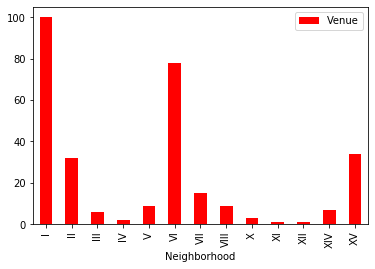

In [148]:
rome_v1 = rome_venues.groupby('Neighborhood').count()
rome_v1 = rome_v1.reset_index()
rome_v1.head()
rome_v1 = rome_v1[['Neighborhood','Venue']]
rome_v1.plot(kind='bar',x='Neighborhood',y='Venue',color='red')


## Let's find out how many unique categories can be curated from all the returned venues

In [138]:
print('There are {} uniques categories.'.format(len(rome_venues['Venue Category'].unique())))

There are 76 uniques categories.


In [139]:
rome_venues['Venue Category'].unique()

array(['Sandwich Place', 'Italian Restaurant', 'Ice Cream Shop',
       'Jazz Club', 'Café', 'Hotel', 'Boutique', 'Shopping Mall',
       'Bed & Breakfast', 'Trattoria/Osteria', 'Bar',
       'Brazilian Restaurant', 'Plaza', 'Restaurant', 'Fountain',
       'Juice Bar', 'Diner', 'Cosmetics Shop', 'Japanese Restaurant',
       'Pizza Place', 'Art Museum', 'Monument / Landmark', 'Gift Shop',
       'Fast Food Restaurant', 'Roman Restaurant', 'Garden',
       'Historic Site', 'Theater', 'Mediterranean Restaurant',
       'Dessert Shop', 'Cocktail Bar', 'Lingerie Store', 'Movie Theater',
       'Road', 'Museum', 'Candy Store', 'Accessories Store',
       'Jewelry Store', 'Bakery', 'Clothing Store', 'Steakhouse',
       'Dog Run', 'Seafood Restaurant', 'Nightclub', 'Snack Place', 'Pub',
       'Gym / Fitness Center', 'Electronics Store',
       'Scandinavian Restaurant', 'Coffee Shop', 'Basketball Stadium',
       'Gym Pool', 'Noodle House', 'Gym', 'Basketball Court',
       'Scenic Lookout

## Filterig Venues Category by terms: "Restaurant" "Pizza" and "Osteria"

In [81]:
# Filter Venues by Venue Category name like :  Restaurant or  Osteria or Pizza
dfRomeData = rome_venues[rome_venues['Venue Category'].str.contains('Restaurant', regex=False) | rome_venues['Venue Category'].str.contains('Pizza', regex=False) | rome_venues['Venue Category'].str.contains('Osteria', regex=False) ]
dfRomeData.shape


(96, 7)

In [82]:
dfRomeData.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,I,41.9029,12.4855,La Prosciutteria,41.901888,12.484467,Italian Restaurant
7,I,41.9029,12.4855,Sant'Andrea,41.903197,12.483252,Italian Restaurant
10,I,41.9029,12.4855,That's amore,41.902256,12.486001,Italian Restaurant
12,I,41.9029,12.4855,Il Piccolo Buco,41.901254,12.484686,Italian Restaurant
13,I,41.9029,12.4855,Sofia,41.903930,12.484857,Italian Restaurant


In [74]:

dfRomeCount = dfRomeData.groupby('Neighborhood').count().reset_index()
dfRomeCount.head()
#dfRomeCount = dfRomeCount[['Neighborhood', 'Neighborhood Latitude']]
#dfRomeCount.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,I,31,31,31,31,31,31
1,II,14,14,14,14,14,14
2,III,1,1,1,1,1,1
3,IV,1,1,1,1,1,1
4,V,4,4,4,4,4,4


In [75]:
dfRomeCount.head()
dfRomeCount = dfRomeCount[['Neighborhood','Venue']]
dfRomeCount = dfRomeCount.rename(columns={'Neighborhood': 'Municipio', 'Venue': 'Count'})
dfRomeCount.head()

,Municipio,Count
0,I,31
1,II,14
2,III,1
3,IV,1
4,V,4


In [80]:
## Join data
dfJoin = dfMunicipi.merge(dfRomeCount, on='Municipio')
dfJoin

,Municipio,Latitude,Longitude,Count
0,I,41.9029,12.4855,31
1,II,41.9224,12.4983,14
2,III,41.9425,12.5410,1
3,IV,41.9216,12.5537,1
4,V,41.8913,12.5510,4
5,VI,41.8930,12.4827,16
6,VII,41.8501,12.5642,6
7,VIII,41.8599,12.4982,4
8,XI,41.8389,12.4438,1
9,XIV,41.9265,12.4037,1


In [0]:
dfRomeData.head()
dfRomeData.dtypes
df2 = dfRomeData[['Venue Latitude','Venue Longitude']]
rest_locations = df2.to_numpy()
# rest_locations

## Heat map of restaurant location

In [97]:
from folium import plugins
from folium.plugins import HeatMap

map_rome = folium.Map(location=rome_center, zoom_start=11)

# add markers to map
for lat, lng, municipio in zip(dfMunicipi['Latitude'], dfMunicipi['Longitude'], dfMunicipi['Municipio']):
    label = 'Mun {}'.format(municipio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome) 

HeatMap(rest_locations).add_to(map_rome)
folium.Marker(rome_center).add_to(map_rome)

map_rome

## 3. Analyze Each Neighborhood

In [98]:
# one hot encoding
rome_onehot = pd.get_dummies(rome_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rome_onehot['Neighborhood'] = rome_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rome_onehot.columns[-1]] + list(rome_onehot.columns[:-1])
rome_onehot = rome_onehot[fixed_columns]

rome_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Bistro,Boutique,Brazilian Restaurant,Bus Station,Café,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food,Fountain,Garden,Gift Shop,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hotel,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Lingerie Store,Market,Mediterranean Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Nightclub,Noodle House,Pizza Place,Plaza,Pool,Pub,Restaurant,Road,Roman Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Steakhouse,Supermarket,Sushi Restaurant,Temple,Tennis Court,Theater,Tourist Information Center,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar
0,I,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,I,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,I,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,I,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,I,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [99]:
rome_onehot.shape

(299, 77)

## Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [100]:
rome_grouped = rome_onehot.groupby('Neighborhood').mean().reset_index()
rome_grouped

,Neighborhood,Accessories Store,American Restaurant,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Bistro,Boutique,Brazilian Restaurant,Bus Station,Café,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food,Fountain,Garden,Gift Shop,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hotel,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Lingerie Store,Market,Mediterranean Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Nightclub,Noodle House,Pizza Place,Plaza,Pool,Pub,Restaurant,Road,Roman Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Steakhouse,Supermarket,Sushi Restaurant,Temple,Tennis Court,Theater,Tourist Information Center,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar
0,I,0.01,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.0,0.010000,0.000000,0.05,0.01,0.000000,0.050000,0.000000,0.000000,0.000000,0.010000,0.010000,0.01,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.030000,0.010000,0.010000,0.000000,0.000000,0.0,0.010000,0.000000,0.120000,0.080000,0.000000,0.170000,0.01,0.01,0.01,0.010000,0.01,0.000000,0.020000,0.000000,0.020000,0.01,0.020000,0.000000,0.000000,0.040000,0.090000,0.000000,0.000000,0.020000,0.010000,0.010000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.020000,0.000000,0.000000
1,II,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.032258,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.032258,0.000000,0.032258,0.032258,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.0,0.000000,0.000000,0.096774,0.032258,0.000000,0.193548,0.00,0.00,0.00,0.032258,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.032258,0.000000,0.032258,0.064516,0.000000,0.032258,0.064516,0.000000,0.032258,0.000000,0.000000,0.129032,0.000000,0.000000,0.032258,0.032258,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
2,III,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,IV,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
4,V,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.272727,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.090909,0.181818

## Let's confirm the new size

In [101]:
rome_grouped.shape

(13, 77)

## Let's print each neighborhood along with the top 5 most common venues

In [102]:
num_top_venues = 5

for hood in rome_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = rome_grouped[rome_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----I----
                venue  freq
0  Italian Restaurant  0.17
1               Hotel  0.12
2               Plaza  0.09
3      Ice Cream Shop  0.08
4            Boutique  0.05


----II----
                venue  freq
0  Italian Restaurant  0.19
1  Seafood Restaurant  0.13
2               Hotel  0.10
3               Plaza  0.06
4          Restaurant  0.06


----III----
                venue  freq
0               Plaza   0.4
1  Italian Restaurant   0.2
2  Basketball Stadium   0.2
3                Café   0.2
4   Accessories Store   0.0


----IV----
                 venue  freq
0          Pizza Place   0.5
1             Gym Pool   0.5
2    Accessories Store   0.0
3  Monument / Landmark   0.0
4                 Pool   0.0


----V----
                venue  freq
0                Café  0.27
1         Pizza Place  0.18
2  Italian Restaurant  0.09
3      Sandwich Place  0.09
4    Basketball Court  0.09


----VI----
                 venue  freq
0        Historic Site  0.22
1                Hote

## Let's put that into a *pandas* dataframe

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [158]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rome_grouped['Neighborhood']

for ind in np.arange(rome_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rome_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Boutique,Café,Pizza Place,Fountain,Monument / Landmark,Mediterranean Restaurant
1,II,Italian Restaurant,Seafood Restaurant,Hotel,Plaza,Restaurant,Ice Cream Shop,Roman Restaurant,Fountain,Electronics Store,Dog Run
2,III,Plaza,Italian Restaurant,Café,Basketball Stadium,Wine Bar,Fast Food Restaurant,Dessert Shop,Diner,Dog Run,Electronics Store
3,IV,Gym Pool,Pizza Place,Wine Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant
4,V,Café,Pizza Place,Noodle House,Italian Restaurant,Gym,Basketball Court,Chinese Restaurant,Sandwich Place,Electronics Store,Cupcake Shop


<a id='item4'></a>

## 4. Cluster Neighborhoods

In [0]:
distortions = []
K = range(1,10)
rome_grouped_clustering = rome_grouped.drop('Neighborhood', 1)
for k in K:
    #kmeanModel = KMeans(n_clusters=k)
    #kmeanModel.fit(df)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rome_grouped_clustering)
    distortions.append(kmeans.inertia_)

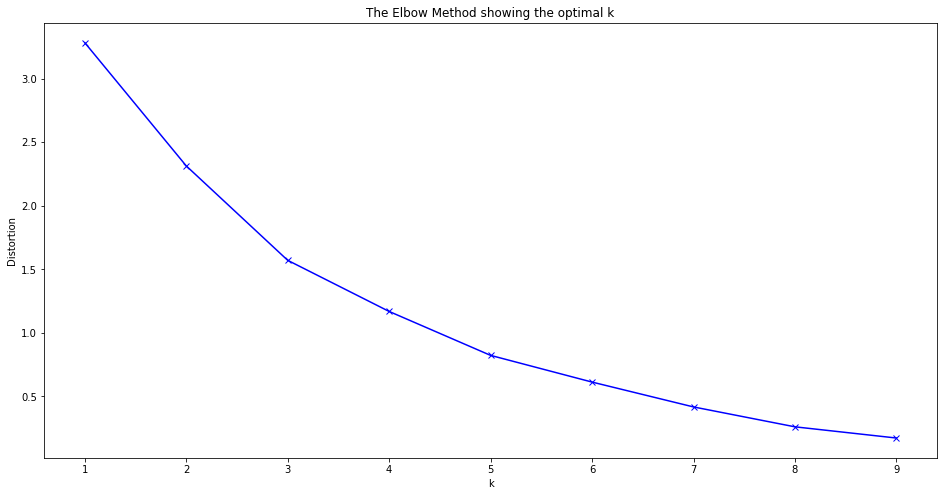

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Run *k*-means to cluster the neighborhood into 5 clusters.

In [156]:
# set number of clusters
kclusters = 5

rome_grouped_clustering = rome_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rome_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_) #[0:10] 

# rome_grouped_clustering.head()
print(rome_grouped_clustering.shape)

rome_grouped_clustering.head()

[0 0 0 3 0 0 0 0 4 2 1 0 0]
(13, 76)


,Accessories Store,American Restaurant,Art Museum,Asian Restaurant,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Bistro,Boutique,Brazilian Restaurant,Bus Station,Café,Chinese Restaurant,Church,Circus,Clothing Store,Cocktail Bar,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food,Fountain,Garden,Gift Shop,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Hotel,Ice Cream Shop,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Lingerie Store,Market,Mediterranean Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Museum,Nightclub,Noodle House,Pizza Place,Plaza,Pool,Pub,Restaurant,Road,Roman Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Snack Place,Steakhouse,Supermarket,Sushi Restaurant,Temple,Tennis Court,Theater,Tourist Information Center,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar
0,0.01,0.0,0.01,0.0,0.01,0.01,0.000000,0.0,0.01,0.000000,0.05,0.01,0.0,0.050000,0.000000,0.0,0.0,0.01,0.01,0.01,0.0,0.010000,0.01,0.000000,0.000000,0.0,0.01,0.0,0.030000,0.01,0.01,0.000000,0.000000,0.0,0.01,0.0,0.120000,0.080000,0.0,0.170000,0.01,0.01,0.01,0.010000,0.01,0.0,0.02,0.0,0.02,0.01,0.02,0.000000,0.000000,0.040000,0.090000,0.0,0.000000,0.020000,0.01,0.010000,0.020000,0.0,0.000000,0.0,0.01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.0
1,0.00,0.0,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.032258,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.032258,0.00,0.032258,0.032258,0.0,0.00,0.0,0.032258,0.00,0.00,0.000000,0.032258,0.0,0.00,0.0,0.096774,0.032258,0.0,0.193548,0.00,0.00,0.00,0.032258,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.032258,0.000000,0.032258,0.064516,0.0,0.032258,0.064516,0.00,0.032258,0.000000,0.0,0.129032,0.0,0.00,0.032258,0.032258,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2,0.00,0.0,0.00,0.0,0.00,0.00,0.000000,0.2,0.00,0.000000,0.00,0.00,0.0,0.200000,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.200000,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.400000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
3,0.00,0.0,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.5,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
4,0.00,0.0,0.00,0.0,0.00,0.00,0.090909,0.0,0.00,0.000000,0.00,0.00,0.0,0.272727,0.090909,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.00,0.00,0.090909,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.090909,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.000000,0.090909,0.181818,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.090909,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [159]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
rome_merged = dfMunicipi
rome_merged = rome_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
rome_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,41.9029,12.4855,0.0,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Boutique,Café,Pizza Place,Fountain,Monument / Landmark,Mediterranean Restaurant
1,II,41.9224,12.4983,0.0,Italian Restaurant,Seafood Restaurant,Hotel,Plaza,Restaurant,Ice Cream Shop,Roman Restaurant,Fountain,Electronics Store,Dog Run
2,III,41.9425,12.5410,0.0,Plaza,Italian Restaurant,Café,Basketball Stadium,Wine Bar,Fast Food Restaurant,Dessert Shop,Diner,Dog Run,Electronics Store
3,IV,41.9216,12.5537,3.0,Gym Pool,Pizza Place,Wine Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant
4,V,41.8913,12.5510,0.0,Café,Pizza Place,Noodle House,Italian Restaurant,Gym,Basketball Court,Chinese Restaurant,Sandwich Place,Electronics Store,Cupcake Shop


Finally, let's visualize the resulting clusters

In [0]:
rome_merged = rome_merged.dropna()
rome_merged = rome_merged.astype({'Cluster Labels': int})

In [117]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rome_merged['Latitude'], rome_merged['Longitude'], rome_merged['Neighborhood'], rome_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [118]:
rome_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,41.9029,12.4855,0,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Boutique,Café,Pizza Place,Fountain,Monument / Landmark,Mediterranean Restaurant
1,II,41.9224,12.4983,0,Italian Restaurant,Seafood Restaurant,Hotel,Plaza,Restaurant,Ice Cream Shop,Roman Restaurant,Fountain,Electronics Store,Dog Run
2,III,41.9425,12.5410,0,Plaza,Italian Restaurant,Café,Basketball Stadium,Wine Bar,Fast Food Restaurant,Dessert Shop,Diner,Dog Run,Electronics Store
3,IV,41.9216,12.5537,3,Gym Pool,Pizza Place,Wine Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant
4,V,41.8913,12.5510,0,Café,Pizza Place,Noodle House,Italian Restaurant,Gym,Basketball Court,Chinese Restaurant,Sandwich Place,Electronics Store,Cupcake Shop


In [120]:
rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]

Index(['Latitude', '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

In [121]:
rome_merged.loc[rome_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I,41.9029,12.4855,0,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Boutique,Café,Pizza Place,Fountain,Monument / Landmark,Mediterranean Restaurant
1,II,41.9224,12.4983,0,Italian Restaurant,Seafood Restaurant,Hotel,Plaza,Restaurant,Ice Cream Shop,Roman Restaurant,Fountain,Electronics Store,Dog Run
2,III,41.9425,12.5410,0,Plaza,Italian Restaurant,Café,Basketball Stadium,Wine Bar,Fast Food Restaurant,Dessert Shop,Diner,Dog Run,Electronics Store
4,V,41.8913,12.5510,0,Café,Pizza Place,Noodle House,Italian Restaurant,Gym,Basketball Court,Chinese Restaurant,Sandwich Place,Electronics Store,Cupcake Shop
5,VI,41.8930,12.4827,0,Historic Site,Hotel,Italian Restaurant,Temple,Monument / Landmark,History Museum,Plaza,Pub,Restaurant,Roman Restaurant
6,VII,41.8501,12.5642,0,Pizza Place,Ice Cream Shop,Miscellaneous Shop,Pub,Italian Restaurant,Chinese Restaurant,Bus Station,Dessert Shop,Diner,Dog Run
7,VIII,41.8599,12.4982,0,Pizza Place,Supermarket,Plaza,Diner,Café,Scenic Lookout,Ice Cream Shop,Italian Restaurant,Bakery,Vegetarian / Vegan Restaurant
12,XIV,41.9265,12.4037,0,Clothing Store,Supermarket,Pizza Place,Gym / Fitness Center,Shopping Mall,Falafel Restaurant,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner
13,XV,41.9409,12.4708,0,Italian Restaurant,Restaurant,Wine Bar,Steakhouse,Cocktail Bar,Hotel,Pizza Place,Ice Cream Shop,Supermarket,Tennis Court


#### Cluster 1

In [122]:
rome_merged.loc[rome_merged['Cluster Labels'] == 0, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,41.9029,Hotel,Plaza,Ice Cream Shop,Boutique,Café,Pizza Place,Fountain,Monument / Landmark,Mediterranean Restaurant
1,41.9224,Seafood Restaurant,Hotel,Plaza,Restaurant,Ice Cream Shop,Roman Restaurant,Fountain,Electronics Store,Dog Run
2,41.9425,Italian Restaurant,Café,Basketball Stadium,Wine Bar,Fast Food Restaurant,Dessert Shop,Diner,Dog Run,Electronics Store
4,41.8913,Pizza Place,Noodle House,Italian Restaurant,Gym,Basketball Court,Chinese Restaurant,Sandwich Place,Electronics Store,Cupcake Shop
5,41.8930,Hotel,Italian Restaurant,Temple,Monument / Landmark,History Museum,Plaza,Pub,Restaurant,Roman Restaurant
6,41.8501,Ice Cream Shop,Miscellaneous Shop,Pub,Italian Restaurant,Chinese Restaurant,Bus Station,Dessert Shop,Diner,Dog Run
7,41.8599,Supermarket,Plaza,Diner,Café,Scenic Lookout,Ice Cream Shop,Italian Restaurant,Bakery,Vegetarian / Vegan Restaurant
12,41.9265,Supermarket,Pizza Place,Gym / Fitness Center,Shopping Mall,Falafel Restaurant,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner
13,41.9409,Restaurant,Wine Bar,Steakhouse,Cocktail Bar,Hotel,Pizza Place,Ice Cream Shop,Supermarket,Tennis Court


#### Cluster 2

In [123]:
rome_merged.loc[rome_merged['Cluster Labels'] == 1, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,41.8695,Fast Food Restaurant,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant,Wine Bar


#### Cluster 3

In [125]:
rome_merged.loc[rome_merged['Cluster Labels'] == 2, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,41.8389,Wine Bar,Food,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant,Fast Food Restaurant


#### Cluster 4

In [124]:
rome_merged.loc[rome_merged['Cluster Labels'] == 3, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,41.9216,Pizza Place,Wine Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store,Falafel Restaurant


#### Cluster 5

In [126]:
rome_merged.loc[rome_merged['Cluster Labels'] == 4, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Latitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,41.7564,Bed & Breakfast,Pool,Wine Bar,Fast Food Restaurant,Cupcake Shop,Dessert Shop,Diner,Dog Run,Electronics Store
